#**Modelos de decisión lineal y cuadrática**

PhD(e). MsC. Ing. Jonnatan Arias Garcia

Universidad del Quindio
jariasg@uniquindio.edu.co

Universidad Tecnologica de Pereira
jonnatan.arias@utp.edu.co



# Objetivos
* Relacionar las distribuciones de los datos con la clase a la que pertenecen.
* Comprender las etapas de entrenamiento y evaluación de un clasificador.

In [28]:
#Setup libraries
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs,make_circles
from sklearn.datasets import load_iris

## Funciones auxiliares

Crean las bases de datos y hacen las gráficas

In [29]:
def blobs():
  #Load database
  X_train, t_train = make_blobs(n_samples=1000, centers=2, random_state=0)
  t_train = t_train*1.0
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def three_blobs():
  #Load database
  X_train, t_train = make_blobs(n_samples=1000, centers=3, random_state=2)
  t_train = (t_train==2)*1.0
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def circles():
  #Load database
  X_train, t_train  = make_circles(n_samples=1000, factor=.5,  noise=.1)
  N = X_train.shape[0]
  #Data grid to evaluate:
  xmin = X_train.min(0)
  xmax = X_train.max(0)
  x1 = np.linspace(xmin[0], xmax[0], 1000) #Malla de puntos para la variable x1
  x2 = np.linspace(xmin[1], xmax[1], 1000) #Malla de puntos para la variable x2
  X1, X2 = np.meshgrid(x1, x2) #Malla de puntos bi-dimensional
  #Datos para evaluar:
  X_test = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
  Ntest = X_test.shape[0]

  clases = list(set(t_train)) #Hace un set y luego una lista
  print('Clases:',clases)
  return X_train,t_train,X_test

def plot_boundaries(X_train,t_train,X_test,y_test,boundaries):
  X1 = X_test[:,0].reshape([1000,1000])
  X2 = X_test[:,1].reshape([1000,1000])
  cmap = ['blue','red']
  colors = [cmap[tn] for tn in t_train.astype(int).ravel()]
  plt.figure(figsize=(5,5))
  plt.scatter(X_train[:,0], X_train[:,1], c=colors)#
  cs = plt.contour(X1, X2, y_test.reshape(X1.shape),boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.show()
  return

def plot_projected_boundaries(X_train,t_train,X_test,t_test,w,mu,boundaries):

  X1 = X_test[:,0].reshape([1000,1000])
  X2 = X_test[:,1].reshape([1000,1000])

  p = np.linspace(0.2,1.1,1000)
  P1, P2 = np.meshgrid(p,p) #Malla de puntos bi-dimensional
  y_plot = sigmoid(w[0] + w[1]*P1 + w[2]*P2)

  cmap = ['blue','red']
  colors = [cmap[tn] for tn in t_train.astype(int).ravel()]

  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.scatter(X_train[:,0], X_train[:,1], c=colors)
  plt.scatter(mu[:,0], mu[:,1], c='red',label='Centroids')
  cs = plt.contour(X1, X2, y_test.reshape(X1.shape),boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.xlabel('$X_1$')
  plt.ylabel('$X_2$')
  plt.legend()

  plt.subplot(1,2,2)
  plt.scatter(Phi_train[:,1], Phi_train[:,2], c=colors)
  cs = plt.contour(P1, P2, y_plot,boundaries)
  plt.clabel(cs, inline=True, fontsize=10)
  plt.xlabel('$\Phi_1$')
  plt.ylabel('$\Phi_2$')
  plt.show()

# Análisis Discriminante Lineal:

##
Calcule `lda_fit` el cual entrega el vector de proyección LDA `w` y el umbral de clasificación `c`:

$\mu_k=mean(X:t==k)$

$\Sigma_k=cov(X:t==k)$

$S_w=\Sigma_1+\Sigma_2$

$w=S_w^{-1}(\mu_1-\mu_2)$

$c=w^\top(\frac{\mu_1+\mu_2}{2})$

In [30]:
def lda_fit(X,t):
  aux1=list(t);
  for x in range(len(t)):
    if(t[x]):
      aux1[x]=True
    else:
      aux1[x]=False

  aux2=list(t);
  for x in range(len(t)):
    if(t[x]):
      aux2[x]=False
    else:
      aux2[x]=True

  u1 = np.mean(X[aux1], axis=0)
  u2 = np.mean(X[aux2], axis=0)

  sigma1 = np.cov(X[aux1], rowvar=False)
  sigma2 = np.cov(X[aux2], rowvar=False)

  Sw = sigma1 + sigma2
  w = np.linalg.inv(Sw)@(u1-u2)
  c = w.T @ ((u1+u2)/2)

  return w,c

##
1. `lda_decision_function` realiza la proyección de las muestras $X$ como:

  $a=Xw$


2. La función `lda_predict` realiza la clasificación de las muestras como:

  $a>=c\rightarrow y = 1$

  $a<c \rightarrow y = 0$

NOTA: La función `lda_predict` usa el resultado de `lda_decision_function`

In [31]:
def lda_decision_function(X,w):
  a = X@w
  return a

def lda_predict(X,w,c):
  a = lda_decision_function(X,w)
  if a>=c:
    y = 1
  if a<c:
    y = 0
  return y

##
Evaluar el clasificador:
Ahora empleamos sus funciones para clasificar unas bases de datos.

Clases: [0.0, 1.0]
[ 0.58996236 -1.743944  ] -3.6300585398462495


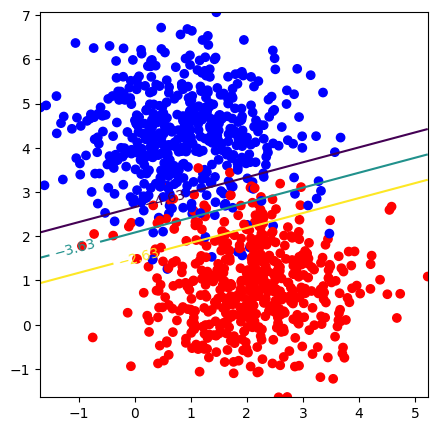

Clases: [0.0, 1.0]
[-0.89870105  0.33134418] -0.7360840351413346


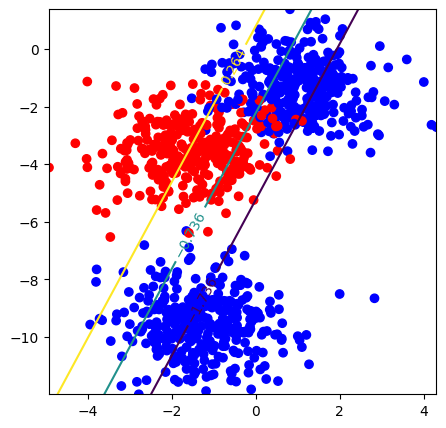

Clases: [0, 1]
[-0.01332766 -0.00352611] 1.4743837050773375e-05


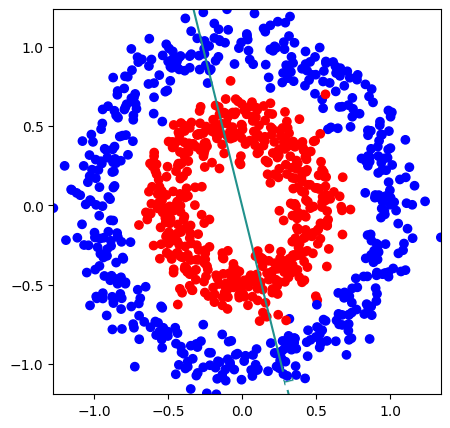

In [32]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  w,c = lda_fit(X_train,t_train)
  print(w,c)

  #Make predictions
  a_test = lda_decision_function(X_test,w)

  #plot results
  boundaries=[c-1,c,c+1]
  plot_boundaries(X_train,t_train,X_test,a_test,boundaries)

##
1. Ahora usando el módulo Linear Discriminant Analysis de scikit-learn (`sklearn.discriminant_analysis.LinearDiscriminantAnalysis`).

2. La variable `a_test` es el valor de la **función de decisión** del objeto LDA evaluada en los datos `X_test`.

3. Finalmente calculamos el **acierto** de clasificación en los datos `X_train,t_train` (con el método `score` del objeto LDA).


In [33]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.955


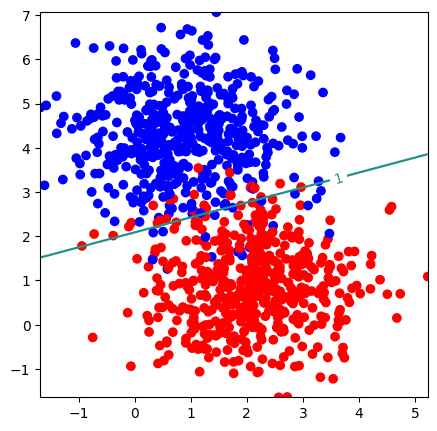

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.84


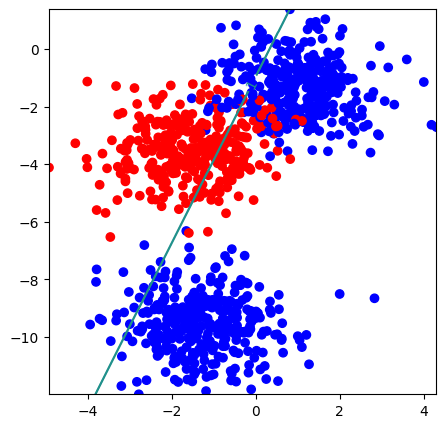

Clases: [0, 1]
El acierto de clasificación en los datos de entrenamiento es 0.505


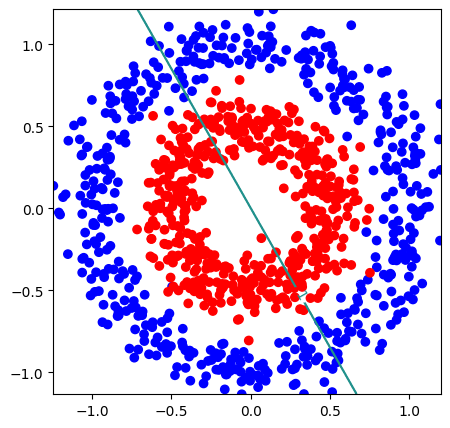

In [34]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Ponga su código acá:
  LDA = LinearDiscriminantAnalysis()
  LDA.fit(X_train, t_train)
  a_test = LDA.predict(X_test)
  #a_test = np.zeros((X_test.shape[0],))

  acc_train = LDA.score(X_train, t_train)
  #acc_train = 0

  print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))

  #Plot results
  boundaries=[c-1,c,c+1]
  plot_boundaries(X_train,t_train,X_test,a_test,boundaries)

# Análisis Discriminante Cuadrático:


##
El modelo generativo usa como probabilidad a posteriori de clase una función sigmoide:

$\sigma(a)=\frac{1}{1+exp(-a)}$

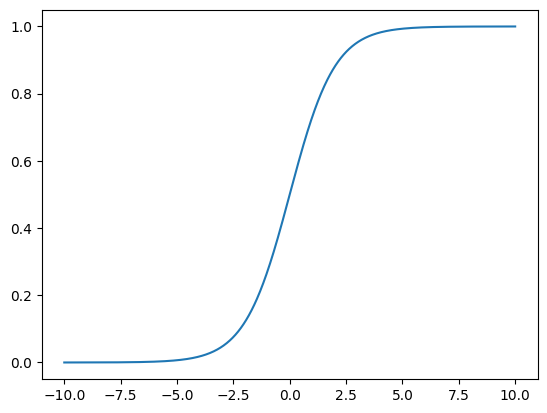

In [35]:
def sigmoid(a):
  #s = np.zeros_like(a)
  s = 1 / (1 + np.exp(-a))
  return s

a = np.linspace(-10,10,1000)
s = sigmoid(a)

plt.plot(a,s)

##
Si se asumen distribuciones de clase Gaussianas, la frontera de decisión será cuadrática:

$a=-\frac{1}{2}x^\top Ax+b^\top x + c$

donde

$A=\Sigma_1^{-1}-\Sigma_2^{-1}$

$b=\mu_1\Sigma_1^{-1}-\mu_2\Sigma_2^{-1}$

$c = - \frac{1}{2}(\mu_1^\top\Sigma_1^{-1}\mu_1+\mu_2^\top\Sigma_2^{-1}\mu_2) +log\left\{\left(\frac{|\Sigma_2|}{|\Sigma_1|}\right)^{1/2}\frac{\pi}{1-\pi}\right\}$

NOTA: Comparando las ecuaciones acá descritas con las vistas en el curso, se han cambiando algunas transpuestas. Esto se debe a que las muestras se reciben como vector fila y el análisis teórico se realizó con vectores columna.

In [36]:
def quad_decision_function(X,S1,S2,m1,m2,pi):
  A = np.linalg.inv(S1) - np.linalg.inv(S2)
  b = m1 @ np.linalg.inv(S1) - m2 @ np.linalg.inv(S2)
  c = -0.5* ( m1.T @ np.linalg.inv(S1) @ m1 - m2.T @ np.linalg.inv(S2) @ m2 ) + np.log( ( (np.linalg.det(S2)/np.linalg.det(S1))**(1/2) )*(pi/(1-pi)) )

  a = []
  for x_n in X:
    a_n = -0.5 * x_n.T @ A @ x_n + b.T @ x_n + c
    a.append(a_n)

  return np.array(a).reshape(X.shape[0],1)


##
La predicción del modelo generativo será entonces
$y = \sigma(a)$

In [37]:
def quad_predict(X,S1,S2,m1,m2,pi):
  a = quad_decision_function(X,S1,S2,m1,m2,pi)
  y = sigmoid(a)
  return y


##
Usando máxima verosimilitud, los parámetros del modelo generativo se pueden calcular como

$\Sigma_1 = cov\{x_n:t_n==1\}$

$\Sigma_2 = cov\{x_n:t_n\neq1\}$

$\mu_1 = mean\{x_n:t_n==1\}$

$\mu_2 = mean\{x_n:t_n\neq1\}$

$\pi=\frac{N_1}{N}$

La función de entrenamiento del modelo generativo:

In [38]:
def quad_fit(X,t):
  #Recuerde que X.shape=(N,D). Use axis=0 en el cálculo de la media y
  # rowvar=False en el cálculo de la covarianza
  '''
  m1 = np.zeros((X.shape[1],))
  S1 = np.zeros(X.shape[1])
  pi = 0
  m2 = np.zeros((X.shape[1],))
  S2 = np.zeros(X.shape[1])
  '''
  aux1=list(t);
  for x in range(len(t)):
    if(t[x]):
      aux1[x]=True
    else:
      aux1[x]=False

  #print("lda aDAKÑLADDLSF   ind1",aux1)
  aux2=list(t);
  for x in range(len(t)):
    if(t[x]):
      aux2[x]=False
    else:
      aux2[x]=True

  m1 = np.mean(X[aux1], axis=0)
  S1 = np.cov(X[aux1], rowvar=False)
  pi = X[aux1].shape[0]/X.shape[0]
  m2 = np.mean(X[aux2], axis=0)
  S2 = np.cov(X[aux2], rowvar=False)

  return S1,S2,m1,m2,pi

##
Evaluar el clasificador:
Ahora empleamos sus funciones para clasificar unas bases de datos:

Clases: [0.0, 1.0]
Mean 1
[2.07391937 0.89566976]
Covariance 1
[[ 0.95302048 -0.01337776]
 [-0.01337776  0.93525532]]
Mean 2
[0.90568611 4.27535188]
Covariance 2
[[ 0.95302048 -0.01337776]
 [-0.01337776  0.93525532]]
Class 1 prior: 0.5


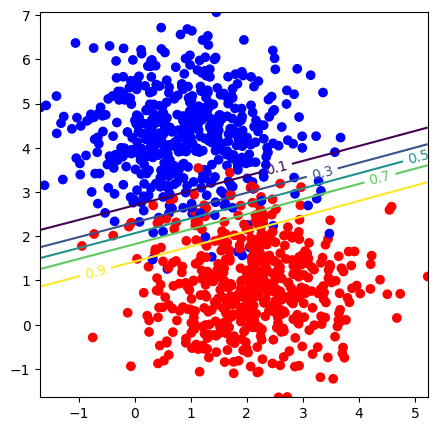

Clases: [0.0, 1.0]
Mean 1
[-1.52351593 -3.4914429 ]
Covariance 1
[[1.01201749 0.11325832]
 [0.11325832 0.94162212]]
Mean 2
[-0.13917698 -5.46127777]
Covariance 2
[[1.01201749 0.11325832]
 [0.11325832 0.94162212]]
Class 1 prior: 0.333


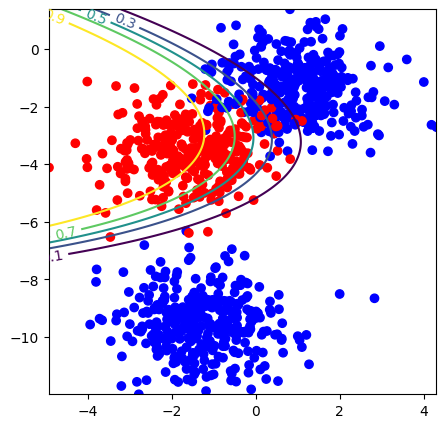

Clases: [0, 1]
Mean 1
[-0.00540942  0.00135373]
Covariance 1
[[0.13721521 0.00087381]
 [0.00087381 0.13556521]]
Mean 2
[-0.0026887   0.00980885]
Covariance 2
[[0.13721521 0.00087381]
 [0.00087381 0.13556521]]
Class 1 prior: 0.5


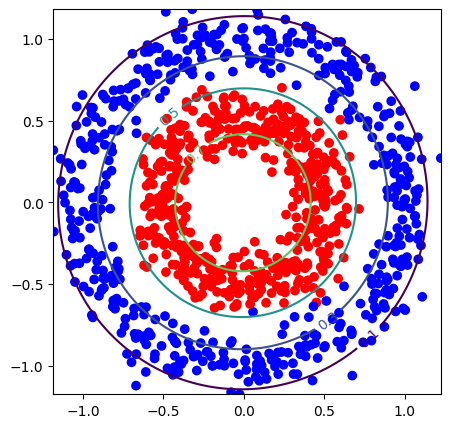

In [39]:
for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  S1,S2,m1,m2,pi = quad_fit(X_train,t_train)

  #Explore parameters
  print('Mean 1')
  print(m1)
  print('Covariance 1')
  print(S1)
  print('Mean 2')
  print(m2)
  print('Covariance 2')
  print(S1)
  print('Class 1 prior: {}'.format(pi))

  #Make predictions
  y_test = quad_predict(X_test,S1,S2,m1,m2,pi)

  #plot results
  boundaries=np.arange(0.1,1,0.2)
  plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

##
Usando skleanr
1. Clasifique las bases de datos empleando el módulo Quadratic Discriminant Analysis de scikit-learn (`sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis`).

2. Guarde en la variable `y_test` el valor de la **probabilidad de predicción** para la clase 1 (columna `0` del resultado del método `predict_proba`) del objeto QDA evaluada en los datos `X_test`.

3. Calcule el **acierto** de clasificación en los datos `X_train,t_train` (emplee el método `score` del objeto QDA).

In [40]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.955


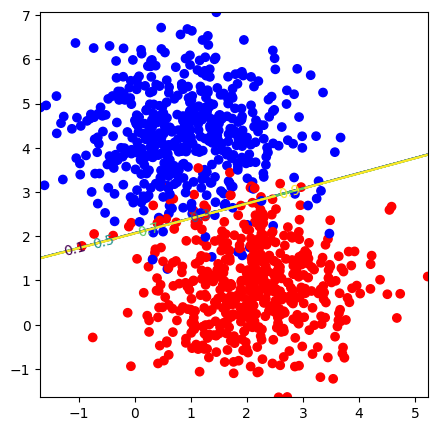

Clases: [0.0, 1.0]
El acierto de clasificación en los datos de entrenamiento es 0.948


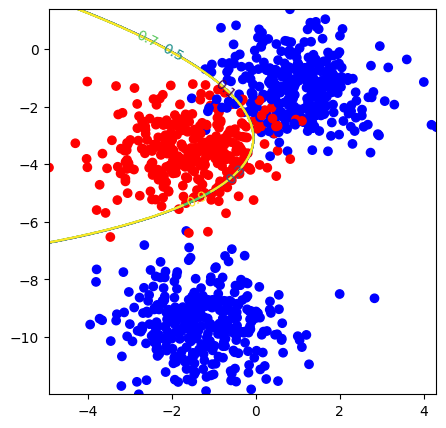

Clases: [0, 1]
El acierto de clasificación en los datos de entrenamiento es 0.982


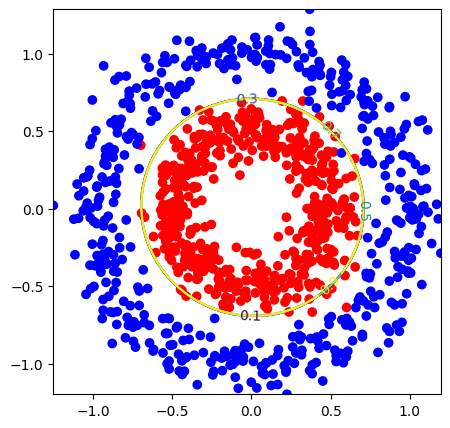

In [41]:

for dataset in [blobs,three_blobs,circles]:
  #Load database
  X_train,t_train,X_test = dataset()

  #Train classifier
  QDA = QuadraticDiscriminantAnalysis()
  QDA.fit(X_train, t_train)

  #Test classifier
  y_test = QDA.predict(X_test)
  acc_train = QDA.score(X_train, t_train)

  print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))

  #plot results
  boundaries=np.arange(0.1,1,0.2)
  plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

#Regresor logístico:

##
El regresor logístico tiene como función de costo el negativo de la log-verosimilitud:

$E(w)=-t^\top log(y) - (1-t)^\top log(1-y)$

Complete la función de costo:

In [42]:
def loss(t,y):
  E = -t.T @ np.log(y) - (1-t).T @ np.log(1-y)
  return E

##
El regresor logístico entrega como predicción el posterior de clase objetivo:

$P(C_1|x)=y(x,w)=\sigma(a)$

donde

$\sigma(a)=\frac{1}{1+exp(-a)}$

y la función de decisión es:

$a=Xw$

Complete la función de predicción.

NOTA: Recuerde que usted ya implementó la función sigmoide $\sigma(a)$ y la función de decisión para un modelo lineal.

In [43]:
def logistic_predict(X,w):
  a = X@w
  y = sigmoid(a)
  return y

##
El regresor logístico se optmiza mediante gradiente descendiente. El gradiente del costo respecto al vector de parámetros es:

$\nabla E(w) = X^\top(y-t)$

Complete la función de gradiente usando sus funciones `logistic_decision_function` y `sigmoid`



In [44]:
def lr_gradient(w,X,t):
  y = logistic_predict(X, w)
  grad = X.T@(y-t)
  return grad

##
El algoritmo de gradiente descendiente:

1.   Inicializar `w` con valores aleatorios de distribución normal (media cero y varianza unitaria). Se debe cumplir que `w.shape=(D,)` siendo `D` el número de características o columnas en `X`.

2.   Predecir con el modelo actual (use `logistic_predict`) en toda la base de datos.

3.   Calcular el costo.

4.   Calcular el gradiente sólo en un subconjuto de la base de datos (use `lr_gradiente`). Consulte el método `np.random.permutation` para generar índices aleatorios.

5.  Actualizar los pesos según la regla del gradente $w(k+1)=w(k)-\eta\nabla E$. La tasa de aprendizaje es un hyperparámetro dado como argumento entrada de la función de entrenamiento.

In [45]:
def logistic_fit(X,t,lr=0.01,maxiter=100):
  #Paso 1: Inicializar w
  w = np.random.normal(0,1,[X.shape[1],])

  L = [] #Lista para almacenar el costo de cada iteración
  for iter in range(maxiter):
    #Paso 2: Realizar predicciones con el posterior de clase P(C1|x)=y(x,w)
    y = logistic_predict(X,w)

    #Paso 3: Calcular el costo
    L.append(loss(t,y))

    #Paso 4: Calcular el gradiente con un subconjunto aleatorio
    ind = np.random.permutation(500)
    grad = lr_gradient(w,X[ind],t[ind])

    #Paso 5: Actualizar los pesos:
    w += -lr * grad

  return w,L

##

Ahora usamos una base de datos que no es linealmente separable, la proyectamos a un nuevo espacio usando RBFs y usamos un el regresor implementado sobre el espacio proyectado.

*   Cambie el número de iteraciones máximas (`maxiter`) e identifique su efecto.

*   Cambie la tasa de aprendizaje (`lr`) e identifique su efecto.



Clases: [0.0, 1.0]


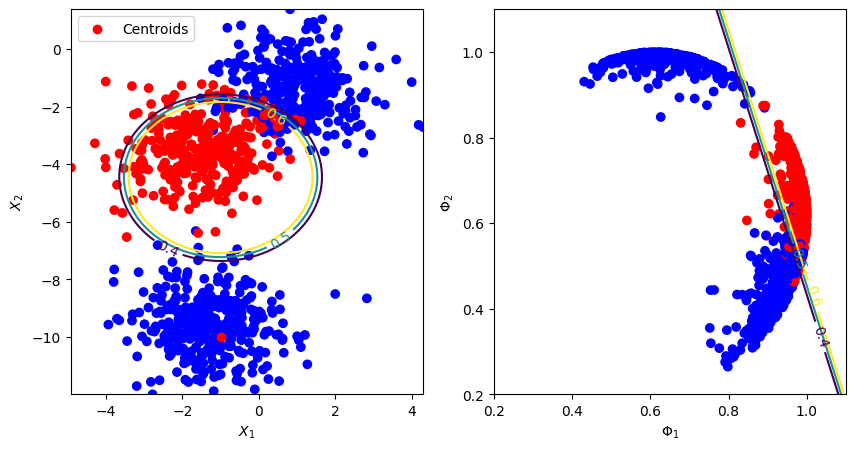

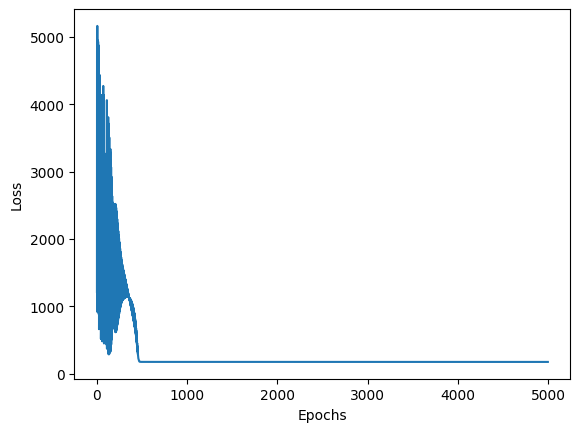

In [46]:
#Basis functions
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import FunctionTransformer

mu = np.array([[-1,-3],[-1,-10]])
rbf = lambda X : np.hstack((np.ones((X.shape[0],1)),rbf_kernel(X,mu,gamma=1e-2)))
transformer = FunctionTransformer(rbf)

#Load database
X_train, t_train, X_test = three_blobs()
t_train = t_train

#Transform data
Phi_train = transformer.fit_transform(X_train)
Phi_test = transformer.fit_transform(X_test)

# Train classfier
w,L=logistic_fit(Phi_train,t_train,lr=0.03,maxiter=5000)

# Make predictions
y_test = logistic_predict(Phi_test,w)

#Plot results
boundaries=[0.4,0.5,0.6]

plot_projected_boundaries(X_train,t_train,X_test,y_test,w,mu,boundaries)

plt.plot(L)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##
1. Clasifique la base de datos anterior empleando el regresor logístico de scikit-learn (`sklearn.linear_model.LogisticRegression`).

2. Guarde en la variable `y_test` el valor de la probabilidad de predicción para la clase 1 (columna `0` del resultado del método `predict_proba`) del objeto Regresor Logístico evaluada en los datos `X_test`.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import *

El acierto de clasificación en los datos de entrenamiento es 0.933


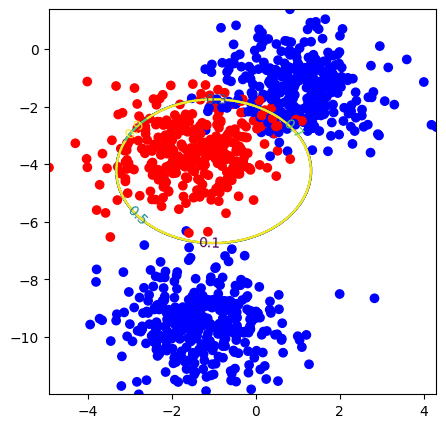

In [48]:
mdl = LogisticRegression()
Phi_train = transformer.fit_transform(X_train)
Phi_test = transformer.fit_transform(X_test)
mdl.fit(Phi_train, t_train)


# Make predictions
y_test = mdl.predict(Phi_test)
acc_train = mdl.score(Phi_train, t_train)
print('El acierto de clasificación en los datos de entrenamiento es {}'.format(acc_train))

#plot results
boundaries=np.arange(0.1,1,0.2)
plot_boundaries(X_train,t_train,X_test,y_test,boundaries)

# Validación cruzada:

## Actividad 1:
La base de datos mnist contiene imágenes de 28 x 28 con dígitos del cero al nueve.


1. Consulte el funcionamiento de la estrategia de validación cruzada (`sklearn.model_selection.cross_validate`)

2. Aplique la validación cruzada a clasificador LDA, QDA y Regresor logístico coon los datos de la base de datos `X` y `t`.

3. Determine el porcentaje de clasificación media y su desviación para cada clasificador.



In [49]:
import pandas as pd
from sklearn.model_selection import cross_validate
df = pd.read_csv('sample_data/mnist_train_small.csv')

t=df.iloc[:,0]
X=df.iloc[:,1:]

print('La base de datos contiene {} imágenes, cada una con {} pixels'.format(X.shape[0],X.shape[1]))

print('Las clases corresponden a dígitos: {} '.format(np.unique(t)))


La base de datos contiene 19999 imágenes, cada una con 784 pixels
Las clases corresponden a dígitos: [0 1 2 3 4 5 6 7 8 9] 


In [50]:
def fit_cross_validate(mdl, X, t, cv=3):
  cv_results = cross_validate(mdl, X, t, cv=cv, return_train_score=True)
  arr = np.array([cv_results['test_score'], cv_results['train_score']])

  return pd.DataFrame( arr.T, columns=['Test Score', 'Train Score']  )


In [51]:

str_models = ['LDA', 'QDA', 'Logistic Regresor']
models = [ LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression() ]

resultados = pd.DataFrame([], columns=['Test-Media', 'Test-Desviación', 'Train-Media', 'Train-Desviación'], index=str_models)

for str_model, model in zip(str_models, models):

  df = fit_cross_validate(model, X_train, t_train, cv=10)

  resultados.loc[str_model]['Test-Media'] = df.mean(axis=0)[0]
  resultados.loc[str_model]['Test-Desviación'] = df.std(axis=0)[0]
  resultados.loc[str_model]['Train-Media'] = df.mean(axis=0)[1]
  resultados.loc[str_model]['Train-Desviación'] = df.std(axis=0)[1]

resultados.head()

,Test-Media,Test-Desviación,Train-Media,Train-Desviación
LDA,0.839,0.04383,0.840444,0.005164
QDA,0.947,0.01767,0.947333,0.002732
Logistic Regresor,0.842,0.043665,0.841889,0.005187
